In [2]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
#y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
#sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')

X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_1y.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_1y.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_idx_1j_1y.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_1y.npy')

In [5]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365 
#dt=np.reshape(dt, (124,1))

In [16]:
def metrics_splits(X, y, splits, dt, percentage, mask, zeros):
    
    box = np.zeros((121,145,121))
    
    l2=X.shape[0]
    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    tn_l=[]

    
    spl2 = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split = 1

    for train_index, test_index in spl2.split(X, y):
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]
        dt_test = dt[test_index]
        print("split:", split)
        split= split + 1
        
                
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
        
        #{0:0.42, 1:0.58}
        clf = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=10e-6)
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        probas_ = probas_[:, 1]
        
        if mask == 1:
            
            mask0 = np.where(dt_test>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test = y_test[mask0][0]
            probas_ = probas_[mask0][0]
            
        conf = confusion_matrix(y_test, pred)
        f1=f1_score(y_test, pred)
        F.append(f1)
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
            
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        tn_l.append(conf[0,0])
        
        #aux = np.zeros((121*145*121))
        #aux[~zeros] = np.asarray(S.get_support())
        #aux = np.reshape(aux, (121,145,121))
        #box = box + aux
        
    #np.save('/home/miquel/ForMiquel/CLEAN2/voxel_appareances_100_splits_full2', box)
    #new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, "img_voxel_appareances_100_splits_full2.nii.gz")
          
    TP = np.sum(tp_l)
    FP = np.sum(fp_l)
    TN = np.sum(tn_l)
    FN = np.sum(fn_l)
    
    F_G=(2*TP)/(2*TP + FP + FN)
    RECALL_G=TP / (TP + FN)
    SPECIFICITY_G= TN / (TN + FP)
    PRECISION_G=TP / (TP + FP)
    
    F = np.mean(F)
    AUC = np.mean(AUC)
    PRECISION = np.mean(PRECISION)
    RECALL = np.mean(RECALL)
    SPECIFICITY = np.mean(SPECIFICITY)
    
    print("F_mean:", F)
    print("AUC_mean:", AUC)
    print("PRECISION_mean:", PRECISION)
    print("RECALL_mean:", RECALL)
    print("SPECIFICITY_mean:", SPECIFICITY)
    print()
    print("F_mean_g:", F_G)
    print("PRECISION_mean_g:", PRECISION_G)
    print("RECALL_mean_g:", RECALL_G)
    print("SPECIFICITY_mean_g:", SPECIFICITY_G)
     
    return F, AUC, PRECISION, RECALL, SPECIFICITY        
        

In [17]:
zeros = np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_X_full2.npy') 
X=np.transpose(np.transpose(X)/dt)
splits = 100
percentage = 3
mask = 0
F, AUC, PRECISION, RECALL, SPECIFICITY = metrics_splits(X, y, splits, dt, percentage, mask, zeros)

split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562823 562824 562825] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    178    179 ..., 562815 562816 562817] are constant.
  UserWarning)


split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    276 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    185    190 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 9
split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562795 562805 562806] are constant.
  UserWarning)


split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    178 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    306 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    70     89    127 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    175 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    149    275 ..., 562780 562788 562807] are constant.
  UserWarning)


split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562815 562816 562817] are constant.
  UserWarning)


split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    297 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 25
split: 26
split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    345    346 ..., 562699 562787 562807] are constant.
  UserWarning)


split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 31
split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     71     89 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    276    290 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562691 562811 562812] are constant.
  UserWarning)


split: 35


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 37


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562558 562576 562788] are constant.
  UserWarning)


split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    178    179 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 40
split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562815 562816 562817] are constant.
  UserWarning)


split: 42


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562807 562811 562812] are constant.
  UserWarning)


split: 43
split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 45


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   358    377    378 ..., 562815 562816 562817] are constant.
  UserWarning)


split: 46


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     79     84 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 47


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562724 562737 562788] are constant.
  UserWarning)


split: 48


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    127 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    175    176 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 50
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    276    293 ..., 562795 562805 562806] are constant.
  UserWarning)


split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 53


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    177    185 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    352    353 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    175 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562807 562811 562812] are constant.
  UserWarning)


split: 58
split: 59


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 62
split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562805 562806 562807] are constant.
  UserWarning)


split: 64


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    177 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 65
split: 66
split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562795 562805 562806] are constant.
  UserWarning)


split: 68
split: 69


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562806 562811 562812] are constant.
  UserWarning)


split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   284    290    394 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 72


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84     89 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 73
split: 74
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562838 562839 562840] are constant.
  UserWarning)


split: 76
split: 77
split: 78
split: 79


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    149 ..., 562718 562765 562780] are constant.
  UserWarning)


split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    284 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 81


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 82


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562788 562811 562812] are constant.
  UserWarning)


split: 83
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    234 ..., 562795 562805 562806] are constant.
  UserWarning)


split: 85
split: 86


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 562823 562824 562825] are constant.
  UserWarning)


split: 87


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    127 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 88
split: 89
split: 90
split: 91


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    178    179 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 92
split: 93


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71     89    149 ..., 562815 562816 562817] are constant.
  UserWarning)


split: 94


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    79     84    173 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 95
split: 96
split: 97


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    149    196 ..., 562836 562839 562840] are constant.
  UserWarning)


split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    175    176 ..., 562834 562835 562838] are constant.
  UserWarning)


split: 99


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   266    290    345 ..., 562831 562832 562833] are constant.
  UserWarning)


split: 100


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    149 ..., 562831 562832 562833] are constant.
  UserWarning)


F_mean: 0.507897253395
AUC_mean: 0.61489010989
PRECISION_mean: 0.516386840713
RECALL_mean: 0.52
SPECIFICITY_mean: 0.688571428571

F_mean_g: 0.514068441065
PRECISION_mean_g: 0.508270676692
RECALL_mean_g: 0.52
SPECIFICITY_mean_g: 0.688571428571


In [36]:
def metrics_repetitions_folds(X, y, repetitions, folds, dt, percentage, mask, zeros):
    
    box = np.zeros((121,145,121))

    l2=X.shape[0]
    X=np.concatenate((X,np.reshape(y, (l2,1))), axis=1)
    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    tn_l=[]
    
    for i in range(0,repetitions):
        
        print("repetition:", i+1)
        X_aux = np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X)
        y_aux = X_aux[:,-1]
        X_aux= X_aux[:,:-1]
        
        dt=np.reshape(dt, (l2,1))
        skf = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)   
        
        fold = 1
        
        for train_index, test_index in skf.split(X, y):  
            X_train = X_aux[train_index,:]
            X_test = X_aux[test_index,:]
            y_train = y_aux[train_index]
            y_test = y_aux[test_index]
            dt_test = dt[test_index]

            print("fold:", fold)
            fold = fold + 1

            S = SelectPercentile(percentile=percentage)
            S.fit(X_train, y_train)
        
            X_train_s = X_train[:,S.get_support()]
            X_test_s = X_test[:,S.get_support()]
            
            clf = LogisticRegression(solver='liblinear', penalty='l2', C=10e-6, class_weight={0: 0.42, 1:0.58})
            clf.fit(X_train_s, y_train)
            pred = clf.predict(X_test_s)
            probas_ = clf.predict_proba(X_test_s)
            
            if mask == 1:
                mask0 = np.where(dt_test>1.09)#~400 days
                mask0 = np.asarray(mask0)
                pred = pred[mask0][0]
                y_test = y_test[mask0][0]
                probas_ = probas_[:, 1]
                probas_ = probas_[mask0][0]
              
            conf = confusion_matrix(y_test, pred)
            fpr, tpr, thresholds = roc_curve(y_test, probas_)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            AUC.append(roc_auc)
            
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            tn_l.append(conf[0,0])
            
            #aux = np.zeros((121*145*121))
            #aux[~zeros] = np.asarray(S.get_support())
            #aux = np.reshape(aux, (121,145,121))
            #box = box + aux
            
    #np.save('/home/miquel/ForMiquel/CLEAN2/fscores_appareances_folds_full2', box)
    #new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, "img_pvalues_appareances_20_splits_full.nii.gz")
    
    TP = np.sum(tp_l)
    FP = np.sum(fp_l)
    TN = np.sum(tn_l)
    FN = np.sum(fn_l)
    
    F=(2*TP)/(2*TP + FP + FN)
    RECALL=TP / (TP + FN)
    SPECIFICITY= TN / (TN + FP)
    PRECISION=TP / (TP + FP)
    AUC=np.mean(AUC)
    

    print("F_mean:", F)
    print("AUC_mean:", AUC)
    print("PRECISION_mean:", PRECISION)
    print("RECALL_mean:", RECALL)
    print("SPECIFICITY_mean:", SPECIFICITY)

            
            
    return F, AUC, PRECISION, RECALL, SPECIFICITY        



In [37]:
zeros = np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_X_full2.npy') 
repetitions = 3
folds = 3
percentage = 1.75
mask = 1
F, AUC, PRECISION, RECALL, SPECIFICITY = metrics_repetitions_folds(X, y, repetitions, folds, dt, percentage, mask, zeros)

repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572735 572736 572737] are constant.
  UserWarning)


repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572703 572708 572709] are constant.
  UserWarning)


F_mean: 0.530805687204
AUC_mean: 0.624197510309
PRECISION_mean: 0.486956521739
RECALL_mean: 0.583333333333
SPECIFICITY_mean: 0.542635658915


percentage: 0.001
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572731 572732 572735] are constant.
  UserWarning)


repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 8
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572634 572670 572685] are constant.
  UserWarning)


repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 10
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572735 572736 572737] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572595 572596 572704] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572735 572736 572737] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572588 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572528 572685 572704] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.464149342384
AUC_mean: 0.580582527261
PRECISION_mean: 0.402798232695
RECALL_mean: 0.547547547548
SPECIFICITY_mean: 0.45054200542
percentage: 0.0287676767677
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572684 572708 572709] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     91 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 3
F_mean: 0.449170565717
AUC_mean: 0.617008964595
PRECISION_mean: 0.385682980278
RECALL_mean: 0.537678207739
SPECIFICITY_mean: 0.436704621567
percentage: 0.0565353535354
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572685 572686 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572634 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572677 572685 572704] are constant.
  UserWarning)


repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572615 572662 572677] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572604 572605 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.45704317488
AUC_mean: 0.580358995074
PRECISION_mean: 0.403076923077
RECALL_mean: 0.527693856999
SPECIFICITY_mean: 0.476383265857
percentage: 0.084303030303
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    349 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572685 572708 572709] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572703 572704 572705] are constant.
  UserWarning)


repetition: 10
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572576 572621 572634] are constant.
  UserWarning)


repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572677 572704 572705] are constant.
  UserWarning)


repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    401 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572605 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 2
fold: 3
F_mean: 0.445582586428
AUC_mean: 0.593553290096
PRECISION_mean: 0.389261744966
RECALL_mean: 0.520958083832
SPECIFICITY_mean: 0.44399185336
percentage: 0.112070707071
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572595 572596 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572662 572677 572685] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572544 572554 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.451048951049
AUC_mean: 0.57648585324
PRECISION_mean: 0.401556420233
RECALL_mean: 0.51445663011
SPECIFICITY_mean: 0.477581521739
percentage: 0.139838383838
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572684 572685 572704] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572670 572685 572686] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 12
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    423 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     83 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572615 572662 572677] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572684 572708 572709] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572677 572684 572685] are constant.
  UserWarning)


fold: 3
F_mean: 0.474003466205
AUC_mean: 0.587608477057
PRECISION_mean: 0.419478527607
RECALL_mean: 0.544820717131
SPECIFICITY_mean: 0.485384092454
percentage: 0.167606060606
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572553 572554 572576] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572595 572596 572704] are constant.
  UserWarning)


repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572634 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572703 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.432550043516
AUC_mean: 0.567335917124
PRECISION_mean: 0.379679144385
RECALL_mean: 0.502527805865
SPECIFICITY_mean: 0.453566621803
percentage: 0.195373737374
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.45104120514
AUC_mean: 0.585966663192
PRECISION_mean: 0.403008709422
RECALL_mean: 0.512072434608
SPECIFICITY_mean: 0.490884537475
percentage: 0.223141414141
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572588 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572509 572525 572544] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572553 572576] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572544 572553] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    436 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572536 572554 572685] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572472 572480 572509] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
F_mean: 0.430390865173
AUC_mean: 0.585076141214
PRECISION_mean: 0.376344086022
RECALL_mean: 0.502564102564
SPECIFICITY_mean: 0.458666666667
percentage: 0.250909090909
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572472 572510 572528] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572536 572554 572704] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572684 572685 572704] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572703 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572707 572708 572709] are constant.
  UserWarning)


repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572662 572677 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.427209705373
AUC_mean: 0.560280212118
PRECISION_mean: 0.369842460615
RECALL_mean: 0.505641025641
SPECIFICITY_mean: 0.44
percentage: 0.278676767677
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572670 572685 572686] are constant.
  UserWarning)


fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572707 572708 572709] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572454 572473 572685] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572528 572553 572576] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.441034633932
AUC_mean: 0.569813406171
PRECISION_mean: 0.398573692552
RECALL_mean: 0.493621197252
SPECIFICITY_mean: 0.478708791209
percentage: 0.306444444444
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572684 572704] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572621 572634 572684] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572662 572677 572704] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572595 572596 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572480 572509 572553] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572605 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     86     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.458889367198
AUC_mean: 0.588147677911
PRECISION_mean: 0.408429118774
RECALL_mean: 0.523575638507
SPECIFICITY_mean: 0.470144131778
percentage: 0.334212121212
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572702 572703 572704] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572621 572634 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     72 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    344 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572685 572704] are constant.
  UserWarning)


fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.456310679612
AUC_mean: 0.608175606274
PRECISION_mean: 0.405808477237
RECALL_mean: 0.521169354839
SPECIFICITY_mean: 0.489548213082
percentage: 0.36197979798
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572596 572704 572705] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572323 572461 572553] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572553 572685 572704] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    423 ..., 572509 572525 572544] are constant.
  UserWarning)


repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572596 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572621 572634 572684] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.427335640138
AUC_mean: 0.569861308737
PRECISION_mean: 0.380878951426
RECALL_mean: 0.486699507389
SPECIFICITY_mean: 0.45
percentage: 0.389747474747
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572553 572554 572684] are constant.
  UserWarning)


repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572536 572553 572554] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572703 572704 572705] are constant.
  UserWarning)


repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572553 572621 572634] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.455201698514
AUC_mean: 0.583047421113
PRECISION_mean: 0.39469808542
RECALL_mean: 0.537612838516
SPECIFICITY_mean: 0.443843031123
percentage: 0.417515151515
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572554 572604 572605] are constant.
  UserWarning)


fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    344 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572634 572670 572685] are constant.
  UserWarning)


repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572670 572685 572704] are constant.
  UserWarning)


repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572615 572662 572677] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572596 572621 572634] are constant.
  UserWarning)


fold: 3
F_mean: 0.477753779698
AUC_mean: 0.599979184465
PRECISION_mean: 0.414232209738
RECALL_mean: 0.564285714286
SPECIFICITY_mean: 0.476923076923
percentage: 0.445282828283
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572554 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.455249569707
AUC_mean: 0.596450977698
PRECISION_mean: 0.392433234421
RECALL_mean: 0.542008196721
SPECIFICITY_mean: 0.453635757171
percentage: 0.47305050505

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572596 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572480 572509 572684] are constant.
  UserWarning)


repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572670 572684 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572604 572605 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572615 572662 572677] are constant.
  UserWarning)


repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.448944420508
AUC_mean: 0.572797597842
PRECISION_mean: 0.391729323308
RECALL_mean: 0.525731584258
SPECIFICITY_mean: 0.454851752022
percentage: 0.500818181818
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572686 572708 572709] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572553 572621 572634] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572685 572708 572709] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572536 572554 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572621 572634 572685] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572536 572554 572684] are constant.
  UserWarning)


fold: 3
F_mean: 0.45501285347
AUC_mean: 0.58284139192
PRECISION_mean: 0.402577710387
RECALL_mean: 0.52315270936
SPECIFICITY_mean: 0.460273972603
percentage: 0.528585858586
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    344 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572588 572708 572709] are constant.
  UserWarning)


repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572595 572596 572684] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572481 572536 572554] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572594 572595 572596] are constant.
  UserWarning)


repetition: 31
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
F_mean: 0.473090277778
AUC_mean: 0.58557742403
PRECISION_mean: 0.417944785276
RECALL_mean: 0.545
SPECIFICITY_mean: 0.485423728814
percentage: 0.556353535354
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572553 572554 572704] are constant.
  UserWarning)


fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572596 572621 572634] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572461 572536 572554] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.459808413161
AUC_mean: 0.57579845333
PRECISION_mean: 0.399421128799
RECALL_mean: 0.541707556428
SPECIFICITY_mean: 0.429945054945
percentage: 0.584121212121
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572481 572621 572634] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572605 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572621 572634 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    349 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572670 572677 572685] are constant.
  UserWarning)


repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572510 572528 572684] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.448186528497
AUC_mean: 0.57750464201
PRECISION_mean: 0.397092578424
RECALL_mean: 0.514370664024
SPECIFICITY_mean: 0.462482946794
percentage: 0.611888888889
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572670 572684 572685] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572621 572634 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572588 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.446660884649
AUC_mean: 0.582972733748
PRECISION_mean: 0.390743550835
RECALL_mean: 0.521255060729
SPECIFICITY_mean: 0.459986550101
percentage: 0.639656565657
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572705 572708 572709] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572685 572704 572705] are constant.
  UserWarning)


repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.440460947503
AUC_mean: 0.569977178916
PRECISION_mean: 0.384214445272
RECALL_mean: 0.516
SPECIFICITY_mean: 0.439322033898
percentage: 0.667424242424
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572662 572677 572685] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572510 572528 572553] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     80 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572702 572703 572704] are constant.
  UserWarning)


repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 3
F_mean: 0.456795484151
AUC_mean: 0.584507296866
PRECISION_mean: 0.398786959818
RECALL_mean: 0.534552845528
SPECIFICITY_mean: 0.468142186452
percentage: 0.695191919192
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572576 572670 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572509 572684 572685] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572684 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572509 572536 572554] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572615 572662 572677] are constant.
  UserWarning)


F_mean: 0.44948630137
AUC_mean: 0.583602339653
PRECISION_mean: 0.391791044776
RECALL_mean: 0.527108433735
SPECIFICITY_mean: 0.448951994591
percentage: 0.72295959596
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572621 572634 572704] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572670 572685 572686] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572670 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572472 572480 572509] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572553 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.471365638767
AUC_mean: 0.594290388073
PRECISION_mean: 0.420928402832
RECALL_mean: 0.535535535536
SPECIFICITY_mean: 0.50135501355
percentage: 0.750727272727
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572525 572544 572685] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572670 572685] are constant.
  UserWarning)


repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572684 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572536 572553 572554] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572677 572685 572704] are constant.
  UserWarning)


F_mean: 0.427304964539
AUC_mean: 0.596267212368
PRECISION_mean: 0.375681995323
RECALL_mean: 0.495375128469
SPECIFICITY_mean: 0.466711051931
percentage: 0.778494949495
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572604 572605] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 10
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572444 572510 572528] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457391304348
AUC_mean: 0.587735966585
PRECISION_mean: 0.4
RECALL_mean: 0.534010152284
SPECIFICITY_mean: 0.470469798658
percentage: 0.806262626263
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572595 572596 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572536 572554 572685] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    436 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572684 572685 572686] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572536 572544 572554] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.429964539007
AUC_mean: 0.590253685236
PRECISION_mean: 0.38583929992
RECALL_mean: 0.485485485485
SPECIFICITY_mean: 0.476964769648
percentage: 0.83403030303
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572528 572553 572685] are constant.
  UserWarning)


fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572634 572670 572685] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.435398230088
AUC_mean: 0.569342127491
PRECISION_mean: 0.376146788991
RECALL_mean: 0.516806722689
SPECIFICITY_mean: 0.464215364412
percentage: 0.861797979798
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     91 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572670 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457067371202
AUC_mean: 0.598307088951
PRECISION_mean: 0.401392111369
RECALL_mean: 0.530674846626
SPECIFICITY_mean: 0.482965931864
percentage: 0.889565656566
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572634 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572596 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572685 572686 572704] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.439844760673
AUC_mean: 0.603157230467
PRECISION_mean: 0.381736526946
RECALL_mean: 0.518819938962
SPECIFICITY_mean: 0.446380697051
percentage: 0.917333333333
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572421 572444 572704] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572662 572677 572685] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572685 572704] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572544 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.417677642981
AUC_mean: 0.570220100868
PRECISION_mean: 0.367658276125
RECALL_mean: 0.483450351053
SPECIFICITY_mean: 0.439106901218
percentage: 0.945101010101
repetition: 1
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572596 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572471 572472 572704] are constant.
  UserWarning)


repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572621 572634 572704] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572472 572604 572605] are constant.
  UserWarning)


fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.427592116538
AUC_mean: 0.598191319171
PRECISION_mean: 0.365835777126
RECALL_mean: 0.514432989691
SPECIFICITY_mean: 0.425249169435
percentage: 0.972868686869
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572621 572634 572684] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572528 572553 572684] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572605 572708 572709] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.440837249039
AUC_mean: 0.588847393206
PRECISION_mean: 0.387387387387
RECALL_mean: 0.511397423191
SPECIFICITY_mean: 0.443383356071
percentage: 1.00063636364
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572596 572685 572704] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572684 572685 572686] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    281 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572703 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.446011458792
AUC_mean: 0.583211903962
PRECISION_mean: 0.394388152767
RECALL_mean: 0.513184584178
SPECIFICITY_mean: 0.478173270651
percentage: 1.0284040404
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572509 572525 572544] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572588 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572595 572596 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572528 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572684 572708 572709] are constant.
  UserWarning)


repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572621 572634 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.454624027658
AUC_mean: 0.579070248104
PRECISION_mean: 0.394302848576
RECALL_mean: 0.536734693878
SPECIFICITY_mean: 0.459531772575
percentage: 1.05617171717
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572473 572685 572704] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572481 572553 572684] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572684 572685] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572634 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.400177462289
AUC_mean: 0.591739549265
PRECISION_mean: 0.354838709677
RECALL_mean: 0.458799593082
SPECIFICITY_mean: 0.450402144772
percentage: 1.08393939394
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572604 572605 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572554 572576 572685] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    355 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572634 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.456692913386
AUC_mean: 0.581067415723
PRECISION_mean: 0.400613967767
RECALL_mean: 0.531027466938
SPECIFICITY_mean: 0.47654155496
percentage: 1.11170707071
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572231 572510 572528] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572621 572634 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572634 572662 572677] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572634 572708 572709] are constant.
  UserWarning)


repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.476832350463
AUC_mean: 0.592130171159
PRECISION_mean: 0.417096536478
RECALL_mean: 0.556538839725
SPECIFICITY_mean: 0.457475994513
percentage: 1.13947474747
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572588 572708 572709] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572596 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.454352441614
AUC_mean: 0.58191923963
PRECISION_mean: 0.398956002983
RECALL_mean: 0.527613412229
SPECIFICITY_mean: 0.448323066393
percentage: 1.16724242424
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572472 572553 572704] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572685 572686 572704] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572303 572323 572553] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457167455876
AUC_mean: 0.585771550113
PRECISION_mean: 0.395678092399
RECALL_mean: 0.54128440367
SPECIFICITY_mean: 0.457161981258
percentage: 1.19501010101
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572480 572509 572684] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572554 572685 572704] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572670 572685 572686] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572604 572605 572704] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.431116905693
AUC_mean: 0.570277839236
PRECISION_mean: 0.376042456406
RECALL_mean: 0.505091649695
SPECIFICITY_mean: 0.448760884126
percentage: 1.22277777778
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572662 572677 572704] are constant.
  UserWarning)


F_mean: 0.471593336181
AUC_mean: 0.604043140867
PRECISION_mean: 0.41628959276
RECALL_mean: 0.543842364532
SPECIFICITY_mean: 0.469863013699
percentage: 1.25054545455
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     86     99 ..., 572731 572732 572735] are constant.
  UserWarning)


repetition: 8
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572634 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572634 572685 572704] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572704 572705] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572670 572685 572686] are constant.
  UserWarning)


fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457295373665
AUC_mean: 0.581417144153
PRECISION_mean: 0.409561752988
RECALL_mean: 0.517623363545
SPECIFICITY_mean: 0.5
percentage: 1.27831313131
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572588 572708 572709] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572554 572604 572605] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572553 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572634 572684 572704] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572684 572708 572709] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     83 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
F_mean: 0.449050086356
AUC_mean: 0.570022088405
PRECISION_mean: 0.389513108614
RECALL_mean: 0.530071355759
SPECIFICITY_mean: 0.454484605087
percentage: 1.30608080808
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572594 572595 572596] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572595 572596 572704] are constant.
  UserWarning)


fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572595 572596 572704] are constant.
  UserWarning)


repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572588 572708 572709] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.466462078036
AUC_mean: 0.581044456007
PRECISION_mean: 0.414330218069
RECALL_mean: 0.533600802407
SPECIFICITY_mean: 0.491204330176
percentage: 1.33384848485
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572554 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572604 572605 572704] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572684 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572596 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572685 572704] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.452732003469
AUC_mean: 0.583754262153
PRECISION_mean: 0.4078125
RECALL_mean: 0.508771929825
SPECIFICITY_mean: 0.476880607315
percentage: 1.36161616162
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572303 572323 572684] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572621 572634 572684] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572685 572708 572709] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572509 572536 572554] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.433651344319
AUC_mean: 0.579492476574
PRECISION_mean: 0.389105058366
RECALL_mean: 0.48971596474
SPECIFICITY_mean: 0.460110041265
percentage: 1.38938383838
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572634 572708 572709] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572223 572264 572461] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572605 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572544 572685 572704] are constant.
  UserWarning)


F_mean: 0.439982150826
AUC_mean: 0.559822763657
PRECISION_mean: 0.394715772618
RECALL_mean: 0.496975806452
SPECIFICITY_mean: 0.490222521915
percentage: 1.41715151515
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572473 572553 572685] are constant.
  UserWarning)


fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572634 572708 572709] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572595 572596 572684] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572605 572621 572634] are constant.
  UserWarning)


repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
F_mean: 0.435224386113
AUC_mean: 0.59890832873
PRECISION_mean: 0.381022979985
RECALL_mean: 0.507403751234
SPECIFICITY_mean: 0.428864569083
percentage: 1.44491919192
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572677 572708 572709] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572703 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    325 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572595 572596 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572596 572621 572634] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572677 572684 572685] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.459915611814
AUC_mean: 0.592442075938
PRECISION_mean: 0.400735294118
RECALL_mean: 0.539603960396
SPECIFICITY_mean: 0.443686006826
percentage: 1.47268686869
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572703 572704 572705] are constant.
  UserWarning)


repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.431101511879
AUC_mean: 0.561356226039
PRECISION_mean: 0.379756468798
RECALL_mean: 0.498501498501
SPECIFICITY_mean: 0.447082767978
percentage: 1.50045454545
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572576 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572702 572703 572704] are constant.
  UserWarning)


repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572662 572677 572704] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     89 ..., 572731 572732 572735] are constant.
  UserWarning)


repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572594 572595 572596] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     89 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572525 572528 572544] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     86 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
F_mean: 0.465403261349
AUC_mean: 0.60233266706
PRECISION_mean: 0.417061611374
RECALL_mean: 0.526420737787
SPECIFICITY_mean: 0.498641304348
percentage: 1.52822222222
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572670 572685 572686] are constant.
  UserWarning)


repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572595 572596 572685] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572509 572525 572544] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572604 572605 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457779682812
AUC_mean: 0.584886638334
PRECISION_mean: 0.400600150038
RECALL_mean: 0.534
SPECIFICITY_mean: 0.458305084746
percentage: 1.55598989899
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572677 572684 572685] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572576 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572576 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572621 572634] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572588 572708 572709] are constant.
  UserWarning)


repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.4180543383
AUC_mean: 0.567016779183
PRECISION_mean: 0.36664104535
RECALL_mean: 0.48623853211
SPECIFICITY_mean: 0.448460508701
percentage: 1.58375757576
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.474660074166
AUC_mean: 0.591616605517
PRECISION_mean: 0.416184971098
RECALL_mean: 0.552253116012
SPECIFICITY_mean: 0.435754189944
percentage: 1.61152525253
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572705 572708 572709] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572553 572554 572685] are constant.
  UserWarning)


fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572553 572684 572685] are constant.
  UserWarning)


fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.477868500215
AUC_mean: 0.606045311429
PRECISION_mean: 0.413998510797
RECALL_mean: 0.565040650407
SPECIFICITY_mean: 0.472166331321
percentage: 1.63929292929
repetition: 1
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572544 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 17
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572544 572553 572704] are constant.
  UserWarning)


fold: 2
fold: 3
F_mean: 0.44262295082
AUC_mean: 0.576823432691
PRECISION_mean: 0.381696428571
RECALL_mean: 0.526694045175
SPECIFICITY_mean: 0.446369087275
percentage: 1.66706060606
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572461 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.454193548387
AUC_mean: 0.595793829188
PRECISION_mean: 0.40243902439
RECALL_mean: 0.521224086871
SPECIFICITY_mean: 0.463748290014
percentage: 1.69482828283
repetition: 1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     86 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572480 572481 572509] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572621 572634 572684] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.435278630978
AUC_mean: 0.56314395605
PRECISION_mean: 0.387802971071
RECALL_mean: 0.496
SPECIFICITY_mean: 0.469152542373
percentage: 1.7225959596
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572677 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    281 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4      5     13 ..., 572692 572702 572703] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572595 572596 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.44989059081
AUC_mean: 0.578346030765
PRECISION_mean: 0.405043341214
RECALL_mean: 0.505905511811
SPECIFICITY_mean: 0.482522275531
percentage: 1.75036363636
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572595 572596 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572528 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572510 572528 572704] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572621 572634 572685] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572677 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.461275139067
AUC_mean: 0.596854402854
PRECISION_mean: 0.406485671192
RECALL_mean: 0.533135509397
SPECIFICITY_mean: 0.462431693989
percentage: 1.77813131313
repetition: 1
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fo

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572685 572704 572705] are constant.
  UserWarning)


F_mean: 0.440052700922
AUC_mean: 0.55769078246
PRECISION_mean: 0.388372093023
RECALL_mean: 0.507598784195
SPECIFICITY_mean: 0.469758064516
percentage: 1.8058989899
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572461 572481 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572634 572684 572704] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572576 572621 572634] are constant.
  UserWarning)


F_mean: 0.460297239915
AUC_mean: 0.593363568939
PRECISION_mean: 0.40059127864
RECALL_mean: 0.540918163673
SPECIFICITY_mean: 0.449422946368
percentage: 1.83366666667
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572670 572677 572685] are constant.
  UserWarning)


repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572670 572677 572685] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     91     99 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.456569183763
AUC_mean: 0.576478131001
PRECISION_mean: 0.405740884407
RECALL_mean: 0.521956087824
SPECIFICITY_mean: 0.479972844535
percentage: 1.86143434343
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572670 572684 572685] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572553 572554 572576] are constant.
  UserWarning)


fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572554 572670 572685] are constant.
  UserWarning)


fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572461 572480 572509] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.458053691275
AUC_mean: 0.582846168957
PRECISION_mean: 0.399707174231
RECALL_mean: 0.536345776031
SPECIFICITY_mean: 0.437199725463
percentage: 1.8892020202
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572471 572472 572704] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572553 572554 572576] are constant.
  UserWarning)


fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572634 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.445957446809
AUC_mean: 0.577750987246
PRECISION_mean: 0.386430678466
RECALL_mean: 0.527162977867
SPECIFICITY_mean: 0.438217420662
percentage: 1.91696969697
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572481 572536 572554] are constant.
  UserWarning)


fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572677 572685 572686] are constant.
  UserWarning)


fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572461 572536 572554] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.440692640693
AUC_mean: 0.582032691778
PRECISION_mean: 0.380703066567
RECALL_mean: 0.523124357657
SPECIFICITY_mean: 0.448735019973
percentage: 1.94473737374
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572510 572528 572704] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.463113006397
AUC_mean: 0.611516845521
PRECISION_mean: 0.404921700224
RECALL_mean: 0.540836653386
SPECIFICITY_mean: 0.457511896669
percentage: 1.97250505051
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572605 572708 572709] are constant.
  UserWarning)


repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572264 572444 572461] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     86 ..., 572733 572736 572737] are constant.
  UserWarning)


F_mean: 0.487081745023
AUC_mean: 0.604097018595
PRECISION_mean: 0.434947049924
RECALL_mean: 0.553416746872
SPECIFICITY_mean: 0.479805013928
percentage: 2.00027272727
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572662 572677 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572677 572685 572686] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572634 572684 572685] are constant.
  UserWarning)


repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572472 572604 572605] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572684 572685 572704] are constant.
  UserWarning)


repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572670 572685 572686] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.469690546842
AUC_mean: 0.59708889711
PRECISION_mean: 0.411895910781
RECALL_mean: 0.546351084813
SPECIFICITY_mean: 0.458590006845
percentage: 2.02804040404
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    325 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572323 572536 572554] are constant.
  UserWarning)


repetition: 24
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572596 572684 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572686 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.467521367521
AUC_mean: 0.585049189289
PRECISION_mean: 0.405485544848
RECALL_mean: 0.551967709384
SPECIFICITY_mean: 0.459568733154
percentage: 2.05580808081
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572670 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572704 572708 572709] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     89     90 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572472 572510 572528] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572544 572553 572576] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572702 572703 572704] are constant.
  UserWarning)


repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.465894465894
AUC_mean: 0.595133199812
PRECISION_mean: 0.404619970194
RECALL_mean: 0.549039433771
SPECIFICITY_mean: 0.462314939435
percentage: 2.08357575758
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572596 572621 572634] are constant.
  UserWarning)


fold: 3
repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     90 ..., 572735 572736 572737] are constant.
  UserWarning)


repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572554 572685 572704] are constant.
  UserWarning)


fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572712 572713 572714] are constant.
  UserWarning)


repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.458457605454
AUC_mean: 0.585711349133
PRECISION_mean: 0.404207362885
RECALL_mean: 0.529527559055
SPECIFICITY_mean: 0.456477039068
percentage: 2.11134343434
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572621 572634 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572605 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572703 572708 572709] are constant.
  UserWarning)


repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572621 572634 572684] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572480 572509 572704] are constant.
  UserWarning)


repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572634 572708 572709] are constant.
  UserWarning)


repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572670 572685 572704] are constant.
  UserWarning)


repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.437854339294
AUC_mean: 0.578566669124
PRECISION_mean: 0.386451116243
RECALL_mean: 0.505030181087
SPECIFICITY_mean: 0.461850101283
percentage: 2.13911111111
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572702 572703 572704] are constant.
  UserWarning)


repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    355 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     86 ..., 572728 572729 572730] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572686 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572554 572684 572704] are constant.
  UserWarning)


repetition: 15
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572677 572685 572704] are constant.
  UserWarning)


repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.476515798463
AUC_mean: 0.561516280258
PRECISION_mean: 0.41954887218
RECALL_mean: 0.551383399209
SPECIFICITY_mean: 0.472317156528
percentage: 2.16687878788
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetitio

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572670 572677 572685] are constant.
  UserWarning)


fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572662 572677 572704] are constant.
  UserWarning)


repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.43838028169
AUC_mean: 0.587276426081
PRECISION_mean: 0.384259259259
RECALL_mean: 0.510245901639
SPECIFICITY_mean: 0.467645096731
percentage: 2.19464646465
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572472 572604 572605] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572604 572605] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.472421052632
AUC_mean: 0.589640529882
PRECISION_mean: 0.411894273128
RECALL_mean: 0.5538005923
SPECIFICITY_mean: 0.452120383037
percentage: 2.22241414141
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
rep

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572509 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572596 572708 572709] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572472 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572604 572605 572685] are constant.
  UserWarning)


repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.444251626898
AUC_mean: 0.590672255724
PRECISION_mean: 0.387878787879
RECALL_mean: 0.519796954315
SPECIFICITY_mean: 0.457718120805
percentage: 2.25018181818
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572634 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572481 572553 572704] are constant.
  UserWarning)


fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.44196044712
AUC_mean: 0.588252586349
PRECISION_mean: 0.38675696012
RECALL_mean: 0.51554663992
SPECIFICITY_mean: 0.448579161028
percentage: 2.27794949495
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572662 572677 572704] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572634 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     90 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572686 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.464426014841
AUC_mean: 0.577297352594
PRECISION_mean: 0.411764705882
RECALL_mean: 0.532532532533
SPECIFICITY_mean: 0.485094850949
percentage: 2.30571717172
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetiti

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.442701525054
AUC_mean: 0.581804562798
PRECISION_mean: 0.388676358072
RECALL_mean: 0.514170040486
SPECIFICITY_mean: 0.462676529926
percentage: 2.33348484848
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572595 572596 572685] are constant.
  UserWarning)


fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572686 572704 572705] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.42888024211
AUC_mean: 0.586189879078
PRECISION_mean: 0.375473126419
RECALL_mean: 0.5
SPECIFIC

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572454 572473 572685] are constant.
  UserWarning)


fold: 3
repetition: 3
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      4     13 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572553 572576 572685] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572528 572670 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.437802197802
AUC_mean: 0.590799667748
PRECISION_mean: 0.387247278383
RECALL_mean: 0.50353892821
SPECIFICITY_mean: 0.469717362046
percentage: 2.38902020202
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572615 572662 572677] are constant.
  UserWarning)


fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     72 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572703 572704 572705] are constant.
  UserWarning)


fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572670 572677 572685] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.457995735608
AUC_mean: 0.578757784225
PRECISION_mean: 0.405589123867
RECALL_mean: 0.525954946131
SPECIFICITY_mean: 0.458734525447
percentage: 2.41678787879
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    349 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 22
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572536 572554 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 23
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572553 572576 572684] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572480 572509 572553] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.410460992908
AUC_mean: 0.57246177734
PRECISION_mean: 0.362284820031
RECALL_mean: 0.473415132924
SPECIFICITY_mean: 0.455577822311
percentage: 2.47232323232
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetitio

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572707 572708 572709] are constant.
  UserWarning)


F_mean: 0.442132639792
AUC_mean: 0.585386779134
PRECISION_mean: 0.386071158213
RECALL_mean: 0.51724137931
SPECIFICITY_mean: 0.455339153794
percentage: 2.50009090909
repetition: 1
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572528 572684 572704] are constant.
  UserWarning)


repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572471 572472 572553] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572554 572604 572605] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572528 572536 572554] are constant.
  UserWarning)


fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572677 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
F_mean: 0.445302445302
AUC_mean: 0.585509424213
PRECISION_mean: 0.389055472264
RECALL_mean: 0.520561685055
SPECIFICITY_mean: 0.448579161028
percentage: 2.52785858586
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572553 572554 572576] are constant.
  UserWarning)


fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.433954092681
AUC_mean: 0.574927894534
PRECISION_mean: 0.380410022779
RECALL_mean: 0.505040322581
SPECIFICITY_mean: 0.449763991908
percentage: 2.55562626263
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572621 572634 572684] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572554 572621 572634] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.4588441331
AUC_mean: 0.624205576061
PRECISION_mean: 0.400918133129
RECALL_mean: 0.536335721597
SPECIFICITY_mean: 0.477303070761
percentage: 2.58339393939
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572536 572554 572685] are constant.
  UserWarning)


fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 11
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572596 572685 572704] are constant.
  UserWarning)


repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)


repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572685 572704 572705] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.445975032286
AUC_mean: 0.588944488593
PRECISION_mean: 0.402173913043
RECALL_mean: 0.500483091787
SPECIFICITY_mean: 0.465277777778
percentage: 2.61116161616
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetiti

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572621 572634 572685] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    196 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 3
F_mean: 0.439666520404
AUC_mean: 0.587038563868
PRECISION_mean: 0.380699088146
RECALL_mean: 0.520249221184
SPECIFICITY_mean: 0.460978835979
percentage: 2.63892929293
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572323 572461 572684] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572595 572596 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.445497630332
AUC_mean: 0.585435705454
PRECISION_mean: 0.392261001517
RECALL_mean: 0.515453639083
SPECIFICITY_mean: 0.455842391304
percentage: 2.6666969697
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572670 572677 572685] are constant.
  UserWarning)


fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572662 572677 572684] are constant.
  UserWarning)


repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572605 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.440157825515
AUC_mean: 0.596760580102
PRECISION_mean: 0.3934169279
RECALL_mean: 0.499502487562
SPECIFICITY_mean: 0.473469387755
percentage: 2.69446464646
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572536 572554 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572707 572708 572709] are constant.
  UserWarning)


repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.462151394422
AUC_mean: 0.593130451652
PRECISION_mean: 0.411996842936
RECALL_mean: 0.526209677419
SPECIFICITY_mean: 0.497639919083
percentage: 2.72223232323
repetition: 1
f

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572595 572596 572704] are constant.
  UserWarning)


repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572510 572528 572553] are constant.
  UserWarning)


fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3
repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572670 572684 572685] are constant.
  UserWarning)


fold: 3
repetition: 18
fold: 1
fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3
repetition: 20
fold: 1
fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572720 572721 572722] are constant.
  UserWarning)


repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572684 572708 572709] are constant.
  UserWarning)


fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572472 572621 572634] are constant.
  UserWarning)


repetition: 28
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572705 572708 572709] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572621 572634 572684] are constant.
  UserWarning)


F_mean: 0.453643811988
AUC_mean: 0.58370132141
PRECISION_mean: 0.404926866821
RECALL_mean: 0.51568627451
SPECIFICITY_mean: 0.468728522337
percentage: 2.75
repetition: 1
fold: 1
fold: 2
fold: 3
repetition: 2
fold: 1
fold: 2
fold: 3
repetition: 3
fold: 1
fold: 2
fold: 3
repetition: 4
fold: 1
fold: 2
fold: 3
repetition: 5
fold: 1
fold: 2
fold: 3
repetition: 6
fold: 1
fold: 2
fold: 3
repetition: 7
fold: 1
fold: 2
fold: 3
repetition: 8
fold: 1
fold: 2
fold: 3
repetition: 9
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572224 572510 572528] are constant.
  UserWarning)


repetition: 10
fold: 1
fold: 2
fold: 3
repetition: 11
fold: 1
fold: 2
fold: 3
repetition: 12
fold: 1
fold: 2
fold: 3
repetition: 13
fold: 1
fold: 2
fold: 3
repetition: 14
fold: 1
fold: 2
fold: 3
repetition: 15
fold: 1
fold: 2
fold: 3
repetition: 16
fold: 1
fold: 2
fold: 3
repetition: 17
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572677 572684 572704] are constant.
  UserWarning)


repetition: 18
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572662 572677 572704] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 19
fold: 1
fold: 2
fold: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572707 572708 572709] are constant.
  UserWarning)


repetition: 20
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    344 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 2
fold: 3
repetition: 21
fold: 1
fold: 2
fold: 3
repetition: 22
fold: 1
fold: 2
fold: 3
repetition: 23
fold: 1
fold: 2
fold: 3
repetition: 24
fold: 1
fold: 2
fold: 3
repetition: 25
fold: 1
fold: 2
fold: 3
repetition: 26
fold: 1
fold: 2
fold: 3
repetition: 27
fold: 1
fold: 2
fold: 3
repetition: 28
fold: 1
fold: 2
fold: 3
repetition: 29
fold: 1
fold: 2
fold: 3
repetition: 30
fold: 1
fold: 2
fold: 3
repetition: 31
fold: 1
fold: 2
fold: 3
repetition: 32
fold: 1
fold: 2
fold: 3
repetition: 33
fold: 1
fold: 2
fold: 3
F_mean: 0.461401952085
AUC_mean: 0.587066254747
PRECISION_mean: 0.407843137255
RECALL_mean: 0.531154239019
SPECIFICITY_mean: 0.495320855615
[0.45054200542005418, 0.43670462156731416, 0.47638326585695007, 0.4439918533604888, 0.47758152173913043, 0.48538409245411285, 0.45356662180349933, 0.49088453747467925, 0.45866666666666667, 0.44, 0.47870879120879123, 0.47014413177762526, 0.48954821308159135, 0.45000000000000001, 0.44384303112313939, 0.47692307692307695, 0.45363575717144

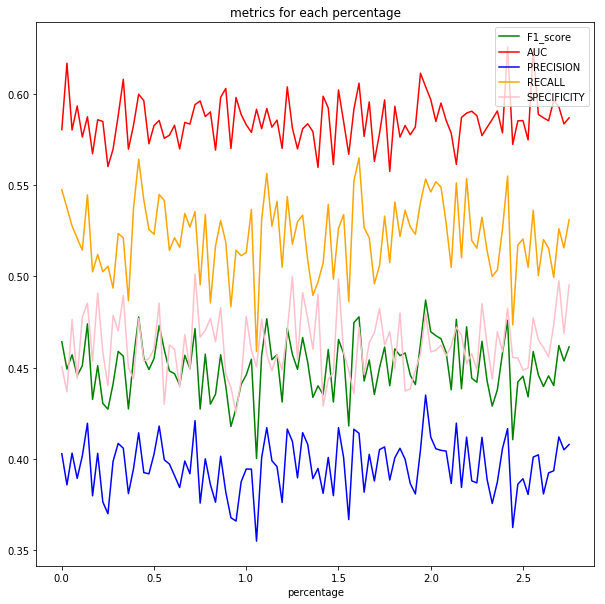

In [57]:
zeros = np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_X_full2.npy') 
splits = 100
mask = 1
folds = 3
repetitions = 33
percentages = np.linspace(0.001 , 2.75, 100)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]

for per in percentages:
    print("percentage:", per)
    #F, AUC, PRECISION, RECALL, SPECIFICITY = metrics_splits(X, y, splits, dt, per, mask, zeros)
    F, AUC, PRECISION, RECALL, SPECIFICITY = metrics_repetitions_folds(X, y, repetitions, folds, dt, percentage, mask)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)

plt.figure(figsize=(10,10))
plt.plot(percentages, f, color='green', label='F1_score')
plt.plot(percentages, auc, color='red', label='AUC')
plt.plot(percentages, precision, color='blue', label='PRECISION')
plt.plot(percentages, recall, color='orange', label='RECALL')
plt.plot(percentages, specificity, color='pink', label='SPECIFICITY')
print(specificity)
plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  
